In [1]:
%%html
<marquee style='width:100%; color: blue;'><b> <h1 style="color:dodgerblue;font-family:verdana;"> BoomBikes Demand Regression Model </h1></b></marquee>


### Problem Statement
BoomBikes, a US bike-sharing provider, aims to understand the demand for shared bikes post-Covid to accelerate revenue growth. They contracted a consulting company to identify significant variables affecting demand and gather data on daily bike demands in the American market.

### Business Goal
Create a model that can analyze the demand for shared bikes using different variables. This model will help management understand demand variations and adjust their business strategy accordingly. It can also be used to understand demand dynamics in a new market.

#### Steps
* 1 - Reading, Understanding and Visualising Data
* 2 - Preparing Data for Modelling
* 3 - Training Models
* 4 - Residual Analysis
* 5 - Predictions and Evaluation of Test Set

### Step 1: Reading, Understanding and Visualisation

In [2]:
#importing EDA libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None)

In [3]:
#read csv file

bike_share = pd.read_csv("day.csv")
bike_share.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#shape of dataset

bike_share.shape

(730, 16)

somewhat small dataset with only 730 entries and 16 features

In [5]:
#data types and info

bike_share.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


all dtypes except for dteday are correct. instant being an index is not needed in this case, will drop column later.

- dteday, we already have year and month, will look into removing this extra info and keep day alone
- season - from data dictionay (1:spring, 2:summer, 3:fall, 4:winter) - will need to map these to the appropriate values then create dummy variables for model
- yr (0:2018, 1:2019)
- mnth if we were to make this into separate dummy variables, it will over complicate the future model. leaving as is
- holiday - whether a holiday or not
- weekday - 0 is sun and 6 is saturday
- workingday - 0 for weekends and holidays
- weathersit : need to split this field for modelling
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature
- atemp - feels like temperature, this is calculated using temp, humidity and windspeed, will likely find it to be highly correlated with these fields 
- hum - humidity
- windspeed - wind speed but no units given

- casual, registered and cnt - number of users with cnt the sum of cas and reg

the categorical variables are on a scale of 0-4 while the numeric variables are much higher, may need to scale later. 

beginning further EDA

In [6]:
#dropping index column then describing numeric data

bike_share.drop(['instant'], axis=1, inplace=True)
bike_share.describe().T  #.T use to transpose the describe table

,count,mean,std,min,25%,50%,75%,max
season,730.0,2.498630,1.110184,1.000000,2.000000,3.000000,3.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,2.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,23.726322,8.150308,3.953480,16.889713,24.368225,30.445775,42.044800
hum,730.0,62.765175,14.237589,0.000000,52.000000,62.625000,72.989575,97.250000


The ranges of the variables appears to be within reason. There are no extradordinary temps, humidities or wind speeds

In [7]:
#creating lists for numeric and categorical variables

num_vars = ['temp','atemp','hum','windspeed','cnt']
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

<Figure size 432x288 with 0 Axes>

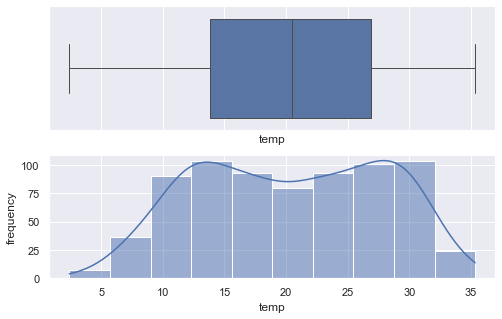

<Figure size 576x360 with 0 Axes>

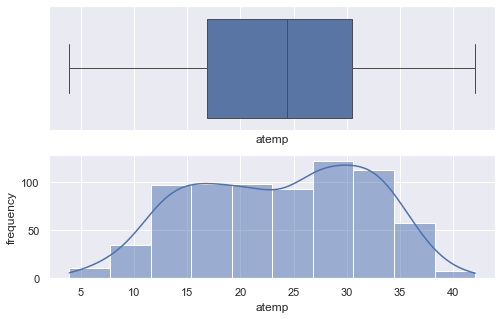

<Figure size 576x360 with 0 Axes>

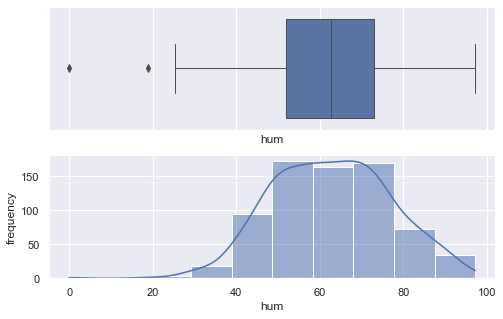

<Figure size 576x360 with 0 Axes>

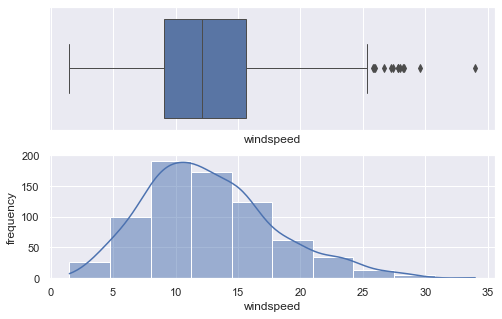

<Figure size 576x360 with 0 Axes>

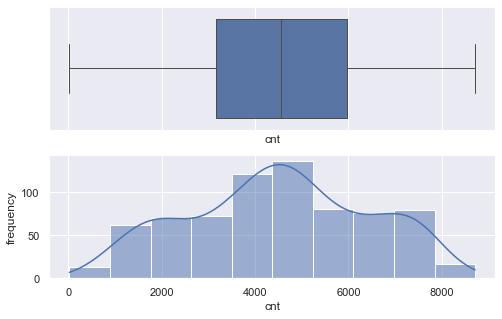

In [8]:
#plotting numeric variables

def numeric_graphs(df, num_vars):
    for col in num_vars:
        plt.figure()
        plt.tight_layout()
        sns.set(rc={"figure.figsize": (8,5)})

        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
        plt.gca().set(xlabel=col, ylabel='frequency')
        sns.boxplot(df[col], ax=ax_box, linewidth=1.0,orient='h')
        sns.histplot(df[col], ax=ax_hist, bins=10, kde=True)
        plt.show()


numeric_graphs(bike_share, num_vars)


windspeed and humidity have a few outliers but because the dataset is so small and the possibility that days with conditions similar to those outliers may hold significance in relation to demand, it may be best to leave them.

BoomBikes appears to operate in a region that has very mild winters but hot summers. Any model built using this data then can only be used for locations with similar temperature ranges
The humidity is also relatively high year round with most values between 40% and 80%. 
Data seems to point to a somewhat subtropical climate with moderate winds, high humidity and high temps

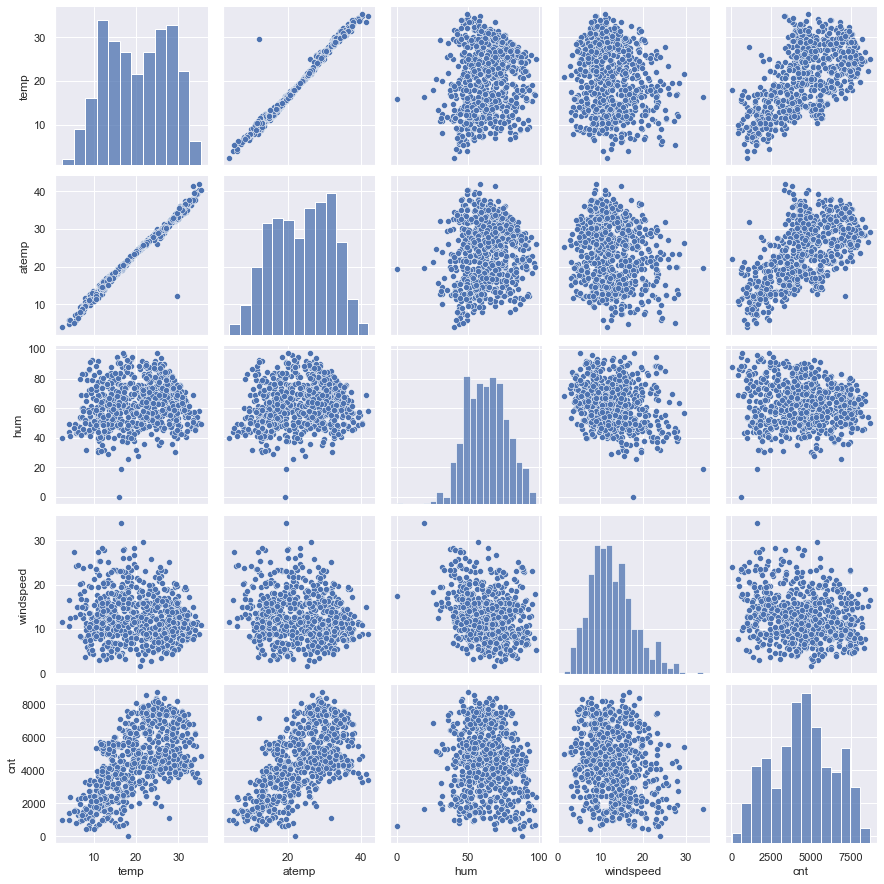

In [9]:
#plotting relationship between numeric variables and response

sns.pairplot(bike_share[['temp','atemp','hum','windspeed','cnt']])
plt.show()



- cnt definitely has some type linear relationship with temperature variables
- temp and atemp are almost assured to be be correlated with each other. 
- hum and windspeed do not appear to have a clear linear relation with cnt

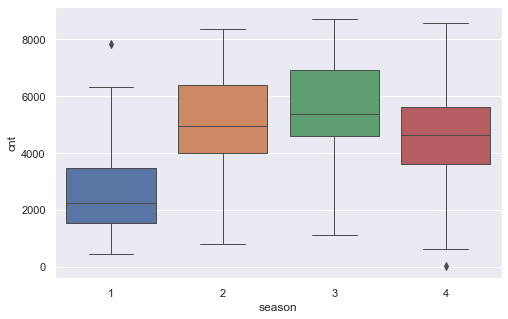

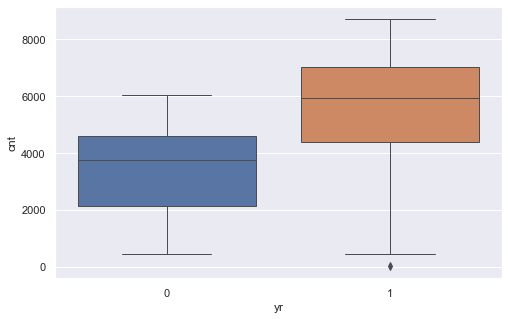

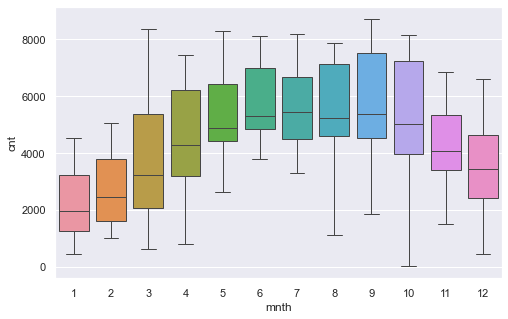

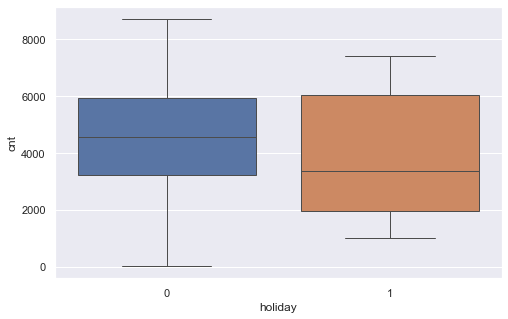

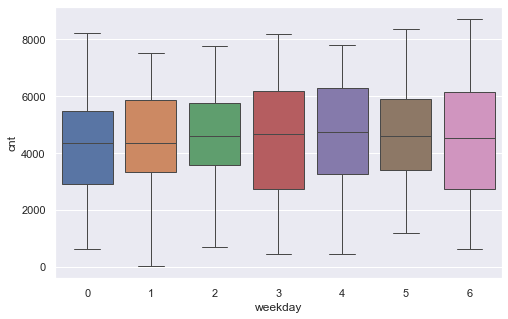

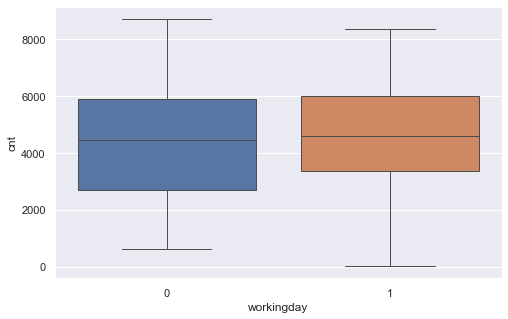

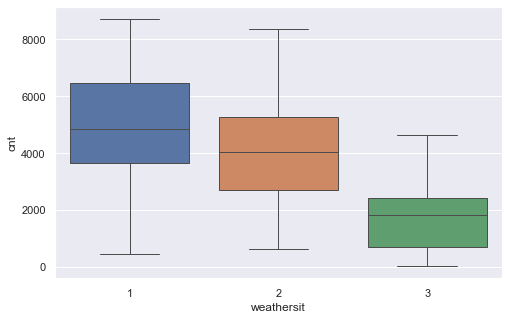

In [10]:
#let's see how the categorical variables interact with count

response = bike_share['cnt']

def cat_boxplots(df, cat_vars):
    for col in cat_vars:
        plt.figure()
        plt.tight_layout()
        sns.set(rc={"figure.figsize": (8,5)})
        
        plt.gca().set(xlabel=col, ylabel='cnt')
        sns.boxplot(x = df[col], y=response, linewidth=1.0,orient='v')
        plt.show()
        
cat_boxplots(bike_share, cat_vars)
    

- season - spring has the lowest ridership with fall having peak ridership. This seems counter intuitive as less widers should ride in winter. Need to take a closer look at seasons and temperatures to ensure they are coded correctly

- yr - ridership was significantly higher in 2019 than 2018, may be a good idea to model the two years separately to see which variables maintain high coefficients between the two years. 

- mnth shows the expected low ridership in winter compared to spring, definitely need to take a closer look at the season variable

- holiday - huge range for non-holiday days with a higher median value as well. could imply persons use the bikeshare service more on non holiday days

- weekday - median of all days is quite similar but wed and sat and sun have the largest ranges of values
- workingday - while the medians are similar, there is a higher minimum and maximum value for non working days than working days. more riders on non working days
- weathersit - clearly days that are considered sunny (clear) are days of highest demand. of note there were no days of heavy precip - value 4

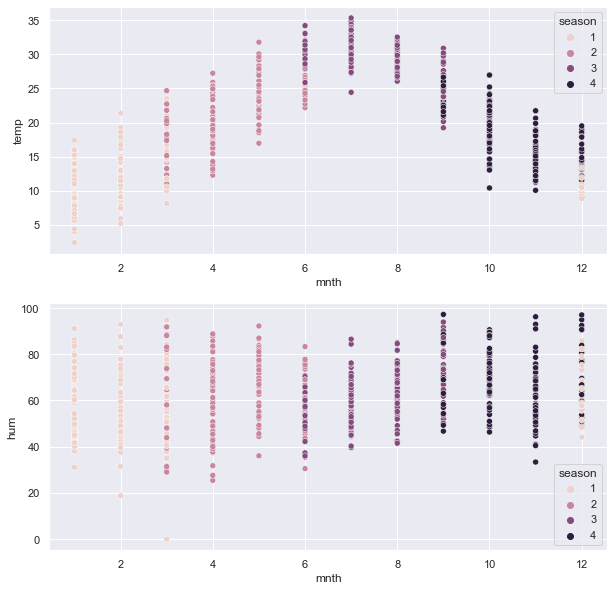

In [11]:
#taking a closer look at the season data
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
sns.scatterplot(data=bike_share, x=bike_share['mnth'], y=bike_share['temp'], hue=bike_share['season'])
plt.subplot(2,1,2)
sns.scatterplot(data=bike_share, x=bike_share['mnth'], y=bike_share['hum'], hue=bike_share['season'])

plt.show()

The seasons are clearly not correctly encoded.

1:winter
2:spring
3:summer
4:autumn

with that understanding, winter is clearly the season with least demand

### Step 2: Preparing Data for Modelling

In [12]:
#non-binary cat columns updates - season and weathersit


bike_share['season'] = bike_share['season'].map({1:'winter',2:'spring',3:'summer',4:'autumn'})

bike_share['weathersit'] = bike_share['weathersit'].map({1:'Clear/Partly Cloudy', 
                                                                            2:'Mist/Cloudy', 
                                                                            3:'Light_Precip', 
                                                                            4:'Heavy_Precip'})

bike_share['weekday'] =  bike_share['weekday'].map({0:'Sun', 1:'Mon', 2:'Tues', 3:'Wed', 4:'Thur',5:'Fri',6:'Sat'})

bike_share['mnth'] = bike_share['mnth'].map({ 1: "January", 2: "February",3: "March", 4: "April",
                                             5: "May", 6: "June", 7: "July", 8: "August",
                                             9: "September", 10: "October", 11: "November", 12: "December"})



bike_share.head()



,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,winter,0,January,0,Sat,0,Mist/Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,winter,0,January,0,Sun,0,Mist/Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,winter,0,January,0,Mon,1,Clear/Partly Cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,winter,0,January,0,Tues,1,Clear/Partly Cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,winter,0,January,0,Wed,1,Clear/Partly Cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [13]:
#create dummy variables from season and weathersit and weekday
#n-1 new variables where n is the number of possible categories within initial variable

season = pd.get_dummies(bike_share['season'], drop_first=True)

weathersit = pd.get_dummies(bike_share['weathersit']) 
#no need to drop first since there are no heavy precip days in BUT they are possible.


#creating dummies for weekday so we can catch the impact of each day of the week and month in the model
#there is significant differences in ridership based on month
dayofweek = pd.get_dummies(bike_share['weekday'])
month = pd.get_dummies(bike_share['mnth'])


#adding the dummies to bike_share
bike_share = pd.concat([dayofweek,month,season, weathersit,bike_share], axis=1)
bike_share.head()

,Fri,Mon,Sat,Sun,Thur,Tues,Wed,April,August,December,February,January,July,June,March,May,November,October,September,spring,summer,winter,Clear/Partly Cloudy,Light_Precip,Mist/Cloudy,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,01-01-2018,winter,0,January,0,Sat,0,Mist/Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,02-01-2018,winter,0,January,0,Sun,0,Mist/Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,03-01-2018,winter,0,January,0,Mon,1,Clear/Partly Cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,04-01-2018,winter,0,January,0,Tues,1,Clear/Partly Cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,05-01-2018,winter,0,January,0,Wed,1,Clear/Partly Cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Will need to drop unnecessary columns now. 
Since weathersit, season, mnth, weekday are now split we can remove these. Additionally casual and registered are part of the response variable and can be dropped. I will not be using dteday here since the weather conditions on one day in 2018 with likely be different on that same day in 2019. 

In [14]:
bike_share.drop(['dteday','season','mnth','weekday','weathersit','casual','registered'], axis=1, inplace=True)
bike_share.columns

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thur', 'Tues', 'Wed', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'spring', 'summer', 'winter',
       'Clear/Partly Cloudy', 'Light_Precip', 'Mist/Cloudy', 'yr', 'holiday',
       'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [15]:
#need to reorder columns so they make sense

col_order = ['Sun','Mon','Tues','Wed','Thur','Fri','Sat',
             'January', 'February', 'March', 'April', 'May', 'June', 'July',
             'August', 'September', 'October', 'November', 'December','spring', 'summer', 'winter',
            'Clear/Partly Cloudy', 'Light_Precip', 'Mist/Cloudy', 'yr', 'holiday',
             'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

bike_share = bike_share.reindex(columns=col_order)
bike_share.head()

,Sun,Mon,Tues,Wed,Thur,Fri,Sat,January,February,March,April,May,June,July,August,September,October,November,December,spring,summer,winter,Clear/Partly Cloudy,Light_Precip,Mist/Cloudy,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,14.110847,18.18125,80.5833,10.749882,985
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,9.305237,11.46350,43.6957,12.522300,1600


In [16]:
# 2019 has more demand than 2018. Will create two separate data sets for the years and see the correlations with cnt

bike_share_2018 = bike_share[bike_share['yr']==0]
bike_share_2019 = bike_share[bike_share['yr']!=0]

In [17]:
bike_share_2018.drop(['yr'], axis=1,inplace=True)
bike_share_2019.drop(['yr'], axis=1,inplace=True)
bike_share_2018.head()


,Sun,Mon,Tues,Wed,Thur,Fri,Sat,January,February,March,April,May,June,July,August,September,October,November,December,spring,summer,winter,Clear/Partly Cloudy,Light_Precip,Mist/Cloudy,holiday,workingday,temp,atemp,hum,windspeed,cnt
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,14.110847,18.18125,80.5833,10.749882,985
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,14.902598,17.68695,69.6087,16.652113,801
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,9.305237,11.46350,43.6957,12.522300,1600


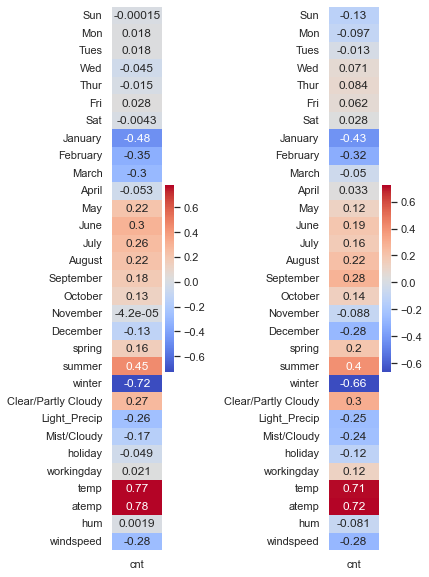

In [18]:
#correlations with cnt

#creating a filter since the heatmap would be unreadable with all 33 varaibles

focus_col = ['cnt']

plt.figure(figsize=(5,10))

plt.subplot(1,2,1)
sns.heatmap(bike_share_2018.corr().filter(focus_col).drop(focus_col), annot=True, cmap='coolwarm')

plt.subplot(1,2,2)
sns.heatmap(bike_share_2019.corr().filter(focus_col).drop(focus_col), annot=True, cmap='coolwarm')



plt.subplots_adjust(wspace=2.5)
plt.show()

comparing the correlations with cnt over the two years 
- wed-sat became more postively correlated with demand
- generally regardless of month demand increased in 2019
- winter became slightly less negatively correlated
- temp became slightly less correlated in 2019


In [19]:
#split dataset into train and test
import sklearn
from sklearn.model_selection import train_test_split


bike_train, bike_test = train_test_split(bike_share, train_size=0.7, test_size=0.3, random_state=100)
bike_train.head()

,Sun,Mon,Tues,Wed,Thur,Fri,Sat,January,February,March,April,May,June,July,August,September,October,November,December,spring,summer,winter,Clear/Partly Cloudy,Light_Precip,Mist/Cloudy,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
653,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,19.201653,23.0423,55.8333,12.208807,7534
576,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,29.246653,33.1448,70.4167,11.083475,7216
426,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,16.980847,20.6746,62.1250,10.792293,4066
728,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,10.489153,11.5850,48.3333,23.500518,1796
482,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,15.443347,18.8752,48.9583,8.708325,4220


In [20]:
#rescaling variables

from sklearn.preprocessing import MinMaxScaler

#instantiate ojbect
scaler = MinMaxScaler()

#scale train set, binary categoricals will stay 0,1 with min max scaling

bike_train[num_vars] = scaler.fit_transform(bike_train[num_vars])
bike_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Sun,510.0,0.143137,0.350557,0.0,0.000000,0.000000,0.000000,1.0
Mon,510.0,0.150980,0.358381,0.0,0.000000,0.000000,0.000000,1.0
Tues,510.0,0.131373,0.338139,0.0,0.000000,0.000000,0.000000,1.0
Wed,510.0,0.158824,0.365870,0.0,0.000000,0.000000,0.000000,1.0
Thur,510.0,0.133333,0.340268,0.0,0.000000,0.000000,0.000000,1.0
Fri,510.0,0.127451,0.333805,0.0,0.000000,0.000000,0.000000,1.0
Sat,510.0,0.154902,0.362166,0.0,0.000000,0.000000,0.000000,1.0
January,510.0,0.088235,0.283915,0.0,0.000000,0.000000,0.000000,1.0
February,510.0,0.066667,0.249689,0.0,0.000000,0.000000,0.000000,1.0
March,510.0,0.098039,0.297660,0.0,0.000000,0.000000,0.000000,1.0


In [21]:
bike_train.shape

(510, 33)

33 columns within the dataset. 

### Step 3: Training the Model

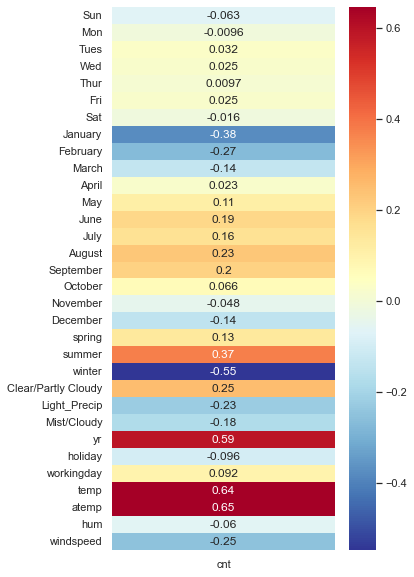

In [22]:
#plot a heatmap to get an idea of correlations - only cnt on x axis to improve readability

plt.figure(figsize=(5,10))
sns.heatmap(bike_train.corr().filter(focus_col).drop(['cnt']), annot=True, cmap='RdYlBu_r')
plt.show()

In [23]:
#import necessary libraries for building regression models

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression

In [24]:
#spliting into response and predictor variables
y_train = bike_train.pop('cnt')
X_train = bike_train

#### Model 1 - using all features

In [25]:
#building model with all predictors first
#add constant to X_train

X_train_sm_1 = sm.add_constant(X_train)

#fit linear model

linear_model_1 = sm.OLS(y_train, X_train_sm_1).fit()

linear_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.72
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          1.35e-180
Time:                        14:05:24   Log-Likelihood:                 527.52
No. Observations:                 510   AIC:                            -997.0
Df Residuals:                     481   BIC:                            -874.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.351e+11   6.51e+11     -0.668      0.504   -1.71e+12    8.45e+11
Sun                  5.563e+11   8.33e+11      0.668      0.504   -1.08e+12    2.19e+12
Mon                  1.462e+10   2.19e+10      0.668      0.504   -2.84e+10    5.76e+10
Tues                 1.462e+10   2.19e+10      0.668      0.504   -2.84e+10    5.76e+10
Wed                  1.462e+10   2.19e+10      0.668      0.504   -2.84e+10    5.76e+10
Thur                 1.462e+10   2.19e+10      0.668      0.504   -2.84e+10    5.76e+10
Fri                  1.462e+10   2.19e+10      0.668      0.504   -2.84e+10    5.76e+10
Sat                  5.563e+11   8.33e+11      0.668      0.504   -1.08e+12    2.19e+12
January             -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
February            -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
March               -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
April               -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
May                 -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
June                -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
July                -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
August              -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
September           -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
October             -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
November            -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
December            -5.573e+10   8.34e+10     -0.668      0.504    -2.2e+11    1.08e+11
spring                 -0.0674      0.030     -2.262      0.024      -0.126      -0.009
summer                 -0.1059      0.028     -3.782      0.000      -0.161      -0.051
winter                 -0.1540      0.026     -5.927      0.000      -0.205      -0.103
Clear/Partly Cloudy  -6.54e+10   9.79e+10     -0.668      0.504   -2.58e+11    1.27e+11
Light_Precip         -6.54e+10   9.79e+10     -0.668      0.504   -2.58e+11    1.27e+11
Mist/Cloudy          -6.54e+10   9.79e+10     -0.668      0.504   -2.58e+11    1.27e+11
yr                      0.2320      0.008     28.707      0.000       0.216       0.248
holiday              5.416e+11   8.11e+11      0.668      0.504   -1.05e+12    2.13e+12
workingday           5.416e+11   8.11e+11      0.668      0.504   -1.05e+12    2.13e+12
temp                    0.4008      0.142      2.814      0.005       0.121       0.681
atemp                   0.0529      0.138      0.382      0.703      -0.219       0.325
hum                    -0.1536      0.039     -3.973      0.000      -0.230      -0.078
win

many fields have high p values but atemp has the highest. adj r squared of 0.844. 
with the r-squared of 0.853 using all variables, we can not achieve a higher r-squared using fewer so any model which reaches a similar r-squared or adj r-squared value would be ideal

Notes indicate there is a strong multicollinearity problems so the final model should be one chosen that lacks this warning as well

In [26]:
#VIF calculation

def VIF(dataframe):
    vif = pd.DataFrame()
    vif['Features'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


VIF(X_train_sm_1)

,Features,VIF
1,Sun,inf
28,workingday,inf
7,Sat,inf
27,holiday,inf
16,September,9.880804e+08
18,November,5.547985e+08
12,May,3.800052e+08
4,Wed,1.109216e+08
5,Thur,8.353752e+07
9,February,8.287713e+07


inf VIF for some values indicating all their variance is explained by other columns. Perfect Multicollinearity. Will drop Sun and run model again

In [27]:
X_train_sm_2 = X_train_sm_1.drop(['Sun'], axis=1)
X_train_sm_2.columns

Index(['const', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'January',
       'February', 'March', 'April', 'May', 'June', 'July', 'August',
       'September', 'October', 'November', 'December', 'spring', 'summer',
       'winter', 'Clear/Partly Cloudy', 'Light_Precip', 'Mist/Cloudy', 'yr',
       'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

#### Model 2 - removed Sun

In [28]:
linear_model_2 = sm.OLS(y_train, X_train_sm_2).fit()

linear_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.42e-181
Time:                        14:05:24   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1967      0.029      6.761      0.000       0.140       0.254
Mon                    -0.0099      0.010     -1.023      0.307      -0.029       0.009
Tues                   -0.0078      0.011     -0.695      0.488      -0.030       0.014
Wed                     0.0058      0.011      0.554      0.580      -0.015       0.026
Thur                    0.0018      0.011      0.165      0.869      -0.020       0.023
Fri                     0.0116      0.011      1.031      0.303      -0.010       0.034
Sat                     0.0545      0.015      3.757      0.000       0.026       0.083
January                -0.0385      0.024     -1.599      0.110      -0.086       0.009
February               -0.0082      0.023     -0.348      0.728      -0.054       0.038
March                   0.0253      0.017      1.473      0.142      -0.008       0.059
April                   0.0240      0.021      1.119      0.264      -0.018       0.066
May                     0.0487      0.022      2.176      0.030       0.005       0.093
June                    0.0223      0.022      1.023      0.307      -0.021       0.065
July                   -0.0153      0.026     -0.586      0.558      -0.066       0.036
August                  0.0401      0.024      1.655      0.099      -0.008       0.088
September               0.1058      0.020      5.359      0.000       0.067       0.145
October                 0.0317      0.021      1.486      0.138      -0.010       0.074
November               -0.0178      0.022     -0.803      0.423      -0.061       0.026
December               -0.0216      0.019     -1.110      0.267      -0.060       0.017
spring                 -0.0672      0.030     -2.257      0.024      -0.126      -0.009
summer                 -0.1054      0.028     -3.770      0.000      -0.160      -0.050
winter                 -0.1540      0.026     -5.932      0.000      -0.205      -0.103
Clear/Partly Cloudy     0.1715      0.011     16.324      0.000       0.151       0.192
Light_Precip           -0.0852      0.022     -3.838      0.000      -0.129      -0.042
Mist/Cloudy             0.1104      0.013      8.812      0.000       0.086       0.135
yr                      0.2322      0.008     28.792      0.000       0.216       0.248
holiday                -0.0424      0.024     -1.793      0.074      -0.089       0.004
workingday              0.0439      0.009      4.689      0.000       0.025       0.062
temp                    0.4013      0.142      2.821      0.005       0.122       0.681
atemp                   0.0506      0.138      0.366      0.714      -0.221       0.322
hum                    -0.1518      0.039     -3.940      0.000      -0.228      -0.076
windspeed              -0.1844      0.026     -7.003      0.000      -0.236      -0.133
===

p-values have fallen significantly, Thur now has the highest value. adj R-sqaured is 0.845

In [29]:
VIF(X_train_sm_2.drop('const',axis=1))

,Features,VIF
0,Mon,inf
12,July,inf
26,workingday,inf
25,holiday,inf
23,Mist/Cloudy,inf
22,Light_Precip,inf
21,Clear/Partly Cloudy,inf
17,December,inf
16,November,inf
1,Tues,inf


Judging from the multiple fields with inf, it may be best to use RFE to reduce the number of columns further. Will start with an RFE of 25 and then run the model again 

#### Model 3 - Using RFE to select features

In [30]:
#building model using RFE selections
X_train_sm_3 = X_train_sm_2.drop(['const'], axis=1) #make a dataset without the contstant

linear_model_3 = LinearRegression()

linear_model_3.fit(X_train_sm_3, y_train)

rfe = RFE(estimator=linear_model_3, n_features_to_select=25)
rfe = rfe.fit(X_train_sm_3, y_train)

list(zip(X_train_sm_3.columns, rfe.support_, rfe.ranking_))

[('Mon', True, 1),
 ('Tues', True, 1),
 ('Wed', True, 1),
 ('Thur', True, 1),
 ('Fri', True, 1),
 ('Sat', False, 6),
 ('January', True, 1),
 ('February', True, 1),
 ('March', True, 1),
 ('April', True, 1),
 ('May', True, 1),
 ('June', True, 1),
 ('July', True, 1),
 ('August', True, 1),
 ('September', True, 1),
 ('October', True, 1),
 ('November', True, 1),
 ('December', True, 1),
 ('spring', False, 5),
 ('summer', False, 4),
 ('winter', False, 3),
 ('Clear/Partly Cloudy', True, 1),
 ('Light_Precip', True, 1),
 ('Mist/Cloudy', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 7),
 ('hum', False, 2),
 ('windspeed', True, 1)]

In [31]:
col = X_train_sm_3.columns[rfe.support_]
print(col)
X_train_sm_3 = X_train_sm_3[col]

Index(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'January', 'February', 'March',
       'April', 'May', 'June', 'July', 'August', 'September', 'October',
       'November', 'December', 'Clear/Partly Cloudy', 'Light_Precip',
       'Mist/Cloudy', 'yr', 'holiday', 'workingday', 'temp', 'windspeed'],
      dtype='object')


In [32]:
X_train_sm_3 = sm.add_constant(X_train_sm_3)

linear_model_3 = sm.OLS(y_train, X_train_sm_3).fit()

linear_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     107.3
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          7.08e-171
Time:                        14:05:24   Log-Likelihood:                 488.80
No. Observations:                 510   AIC:                            -931.6
Df Residuals:                     487   BIC:                            -834.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0990      0.020      4.859      0.000       0.059       0.139
Mon                    -0.0177      0.010     -1.738      0.083      -0.038       0.002
Tues                   -0.0162      0.012     -1.375      0.170      -0.039       0.007
Wed                    -0.0056      0.011     -0.506      0.613      -0.027       0.016
Thur                   -0.0087      0.011     -0.764      0.445      -0.031       0.014
Fri                     0.0021      0.012      0.184      0.854      -0.021       0.025
January                -0.1293      0.020     -6.624      0.000      -0.168      -0.091
February               -0.0940      0.019     -4.981      0.000      -0.131      -0.057
March                  -0.0215      0.014     -1.547      0.122      -0.049       0.006
April                   0.0366      0.015      2.476      0.014       0.008       0.066
May                     0.0513      0.016      3.275      0.001       0.021       0.082
June                    0.0308      0.020      1.573      0.116      -0.008       0.069
July                   -0.0301      0.022     -1.353      0.177      -0.074       0.014
August                  0.0194      0.019      1.011      0.313      -0.018       0.057
September               0.0987      0.017      5.877      0.000       0.066       0.132
October                 0.0953      0.014      6.852      0.000       0.068       0.123
November                0.0483      0.015      3.232      0.001       0.019       0.078
December               -0.0066      0.016     -0.410      0.682      -0.038       0.025
Clear/Partly Cloudy     0.1562      0.010     15.232      0.000       0.136       0.176
Light_Precip           -0.1333      0.020     -6.632      0.000      -0.173      -0.094
Mist/Cloudy             0.0760      0.011      7.202      0.000       0.055       0.097
yr                      0.2373      0.009     27.662      0.000       0.220       0.254
holiday                -0.0722      0.025     -2.936      0.003      -0.121      -0.024
workingday              0.0262      0.008      3.209      0.001       0.010       0.042
temp                    0.3943      0.047      8.325      0.000       0.301       0.487
windspeed              -0.1751      0.026     -6.645      0.000      -0.227      -0.123
==============================================================================
Omnibus:                       61.895   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.311
Skew:                          -0.644   Prob(JB):                     2.79e-32
Kurtosis:                       5.275   Cond. No.                     1.18e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

There are still multi-collinearity issues with the model but the r-sqaured is 0.829. This is 3% lower than before. Will consider this model later if necessary but will return to using model 2 and manual selection for now

#### Model 4 

In [33]:
#model 2 noted high VIF for Mon. Dropping and running again
X_train_sm_4 = X_train_sm_2.drop('Mon', axis=1)

linear_model_4 = sm.OLS(y_train, X_train_sm_4).fit()

linear_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.42e-181
Time:                        14:05:24   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1967      0.029      6.761      0.000       0.140       0.254
Tues                    0.0022      0.015      0.144      0.886      -0.028       0.032
Wed                     0.0158      0.015      1.079      0.281      -0.013       0.044
Thur                    0.0118      0.015      0.777      0.437      -0.018       0.041
Fri                     0.0215      0.015      1.395      0.164      -0.009       0.052
Sat                     0.0545      0.015      3.757      0.000       0.026       0.083
January                -0.0385      0.024     -1.599      0.110      -0.086       0.009
February               -0.0082      0.023     -0.348      0.728      -0.054       0.038
March                   0.0253      0.017      1.473      0.142      -0.008       0.059
April                   0.0240      0.021      1.119      0.264      -0.018       0.066
May                     0.0487      0.022      2.176      0.030       0.005       0.093
June                    0.0223      0.022      1.023      0.307      -0.021       0.065
July                   -0.0153      0.026     -0.586      0.558      -0.066       0.036
August                  0.0401      0.024      1.655      0.099      -0.008       0.088
September               0.1058      0.020      5.359      0.000       0.067       0.145
October                 0.0317      0.021      1.486      0.138      -0.010       0.074
November               -0.0178      0.022     -0.803      0.423      -0.061       0.026
December               -0.0216      0.019     -1.110      0.267      -0.060       0.017
spring                 -0.0672      0.030     -2.257      0.024      -0.126      -0.009
summer                 -0.1054      0.028     -3.770      0.000      -0.160      -0.050
winter                 -0.1540      0.026     -5.932      0.000      -0.205      -0.103
Clear/Partly Cloudy     0.1715      0.011     16.324      0.000       0.151       0.192
Light_Precip           -0.0852      0.022     -3.838      0.000      -0.129      -0.042
Mist/Cloudy             0.1104      0.013      8.812      0.000       0.086       0.135
yr                      0.2322      0.008     28.792      0.000       0.216       0.248
holiday                -0.0523      0.027     -1.916      0.056      -0.106       0.001
workingday              0.0339      0.015      2.270      0.024       0.005       0.063
temp                    0.4013      0.142      2.821      0.005       0.122       0.681
atemp                   0.0506      0.138      0.366      0.714      -0.221       0.322
hum                    -0.1518      0.039     -3.940      0.000      -0.228      -0.076
windspeed              -0.1844      0.026     -7.003      0.000      -0.236      -0.133
==============================================================================
Omnibus:    

adj R-squared is 0.845 and AIC is much lower. improved over model 3 but similar to model 2. P values for many fields remains high

In [34]:
VIF(X_train_sm_4.drop('const', axis=1))

,Features,VIF
15,November,inf
10,June,inf
22,Mist/Cloudy,inf
21,Light_Precip,inf
20,Clear/Partly Cloudy,inf
16,December,inf
14,October,inf
13,September,inf
11,July,inf
12,August,inf


still many field with VIF > 10. removing Nov and running again

#### Model 5 - removed November

In [35]:
X_train_sm_5 = X_train_sm_4.drop('November', axis=1)
linear_model_5 = sm.OLS(y_train, X_train_sm_5).fit()


print(linear_model_5.summary())
print('\n','VIF Scores for Model 5')
print(VIF(X_train_sm_5.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.42e-181
Time:                        14:05:24   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1833    

adj r-sqaured 0.845 and AIC -998.1. Same as model 4. The VIF for Temp is high but very low p-value. atemp has a high VIF and high p-value. Since atemp is definitely correlated with temp, hum and windspeed, I will remove this and run the model again to see if temp remains with a very high VIF. 
NB temp will correlate with month and season

#### Model 6 - Removing atemp

In [36]:
X_train_sm_6 = X_train_sm_5.drop('atemp', axis=1)
linear_model_6 = sm.OLS(y_train, X_train_sm_6).fit()


print(linear_model_6.summary())
print('\n','VIF Scores for Model 6')
print(VIF(X_train_sm_6.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     103.8
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.74e-182
Time:                        14:05:24   Log-Likelihood:                 527.95
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     482   BIC:                            -881.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1836    

AIC only decreased marginally and adj R-squared is the same as before. Will attempt to use RFE now more variables have reduced p-values

#### Model 7 - Using RFE again 15 columns

In [37]:
X_train_sm_7 = X_train_sm_6.drop(['const'], axis=1) #make a dataset without the contstant

linear_model_7 = LinearRegression()

linear_model_7.fit(X_train_sm_7, y_train)

rfe = RFE(estimator=linear_model_7, n_features_to_select=15)
rfe = rfe.fit(X_train_sm_7, y_train)

list(zip(X_train_sm_7.columns, rfe.support_, rfe.ranking_))

[('Tues', False, 14),
 ('Wed', False, 11),
 ('Thur', False, 9),
 ('Fri', False, 8),
 ('Sat', True, 1),
 ('January', False, 7),
 ('February', False, 10),
 ('March', False, 2),
 ('April', False, 6),
 ('May', False, 4),
 ('June', False, 5),
 ('July', False, 13),
 ('August', True, 1),
 ('September', True, 1),
 ('October', True, 1),
 ('December', False, 12),
 ('spring', False, 3),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Clear/Partly Cloudy', True, 1),
 ('Light_Precip', True, 1),
 ('Mist/Cloudy', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [38]:
col = X_train_sm_7.columns[rfe.support_]
print(col)
X_train_sm_7 = X_train_sm_7[col]

Index(['Sat', 'August', 'September', 'October', 'summer', 'winter',
       'Clear/Partly Cloudy', 'Light_Precip', 'Mist/Cloudy', 'yr', 'holiday',
       'workingday', 'temp', 'hum', 'windspeed'],
      dtype='object')


In [39]:
X_train_sm_7 = sm.add_constant(X_train_sm_7)

linear_model_7 = sm.OLS(y_train, X_train_sm_7).fit()

print(linear_model_7.summary())
print('\n','VIF Scores for Model 7')
print(VIF(X_train_sm_7.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.8
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          6.52e-192
Time:                        14:05:24   Log-Likelihood:                 518.43
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1709    

adj R-squred of 0.843, lower AIC than previous models and highest F-statistic. Only holiday is not statistically significant. Clear/Partlycloudy and Misty/Cloudy have VIF > 10 indicating their variation is well explained by other predictors. 

yr has the highest impact on demand outside of temp based on coef. This lines up well with higher usage in 2019 than 2018. 

Will use RFE again to lower to 12 features 

#### Model 8 -  RFE = 12

In [40]:
X_train_sm_8 = X_train_sm_7.drop(['const'], axis=1) #make a dataset without the contstant

linear_model_8 = LinearRegression()

linear_model_8.fit(X_train_sm_8, y_train)

rfe = RFE(estimator=linear_model_8, n_features_to_select=12)
rfe = rfe.fit(X_train_sm_8, y_train)

list(zip(X_train_sm_8.columns, rfe.support_, rfe.ranking_))

[('Sat', False, 3),
 ('August', False, 2),
 ('September', True, 1),
 ('October', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Clear/Partly Cloudy', True, 1),
 ('Light_Precip', True, 1),
 ('Mist/Cloudy', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [41]:
col = X_train_sm_8.columns[rfe.support_]
print(col)
X_train_sm_8 = X_train_sm_8[col]

Index(['September', 'October', 'summer', 'winter', 'Clear/Partly Cloudy',
       'Light_Precip', 'Mist/Cloudy', 'yr', 'holiday', 'temp', 'hum',
       'windspeed'],
      dtype='object')


In [42]:
X_train_sm_8 = sm.add_constant(X_train_sm_8)

linear_model_8 = sm.OLS(y_train, X_train_sm_8).fit()

print(linear_model_8.summary())
print('\n','VIF Scores for Model 8')
print(VIF(X_train_sm_8.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     237.1
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          6.46e-190
Time:                        14:05:25   Log-Likelihood:                 505.26
No. Observations:                 510   AIC:                            -986.5
Df Residuals:                     498   BIC:                            -935.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2041    

AIC increased, adj R-squared decreased a bit, all p-values <0.05. This model, while it has all significant variables, it performs slightly worse than model 7. Will rebuild model 7 but without holiday. Keeping the high VIF values from weathersit because while temp and humidity can explain them, there is no true guarantee that a clear day is a warm day or a cloudy day will be very humid. Will make final determination in later model

#### Model 9 - rebuilt 7 without holiday

In [43]:
X_train_sm_9= X_train_sm_7.drop('holiday', axis=1)

linear_model_9 = sm.OLS(y_train, X_train_sm_9).fit()

print(linear_model_9.summary())
print('\n','VIF Scores for Model 9')
print(VIF(X_train_sm_9.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     210.5
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          2.78e-192
Time:                        14:05:25   Log-Likelihood:                 516.53
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     496   BIC:                            -945.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1644    

Slight increase in AIC, slight decrease in adj r-squared but not truly significant. Will deal with multicollinearity issues since all remaining predictors have p-values <0.05

#### Model 10 - removing Clear/Partly Cloudy

In [44]:
X_train_sm_10= X_train_sm_9.drop('Clear/Partly Cloudy', axis=1)

linear_model_10 = sm.OLS(y_train, X_train_sm_10).fit()

print(linear_model_10.summary())
print('\n','VIF Scores for Model 10')
print(VIF(X_train_sm_10.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     210.5
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          2.78e-192
Time:                        14:05:25   Log-Likelihood:                 516.53
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     496   BIC:                            -945.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3239      0.030     10.645   

Model 10
- adj r-squared 0.843
- f statistic 210.5
- AIC -1005
- p-values <0.05
- first model without multicollinearity note

This model, while it does have multicollinearity with temp and hum, is better than all others so far. It has reduced the number of features used while maintaining a high r squared and providing the second lowest AIC and high f statistic thus far. The VIF of hum and temp will always be high since as temp increases so does humidity and temp is also tied to month which means so is humidity. BUT, since on a granular scale the coefficients of these features are not near 0, this means they do have impact on the day to day demand of bikes. 

#### Model 11 - rebuilt model 9 but this time removing Aug

In [45]:
X_train_sm_11= X_train_sm_9.drop('August', axis=1)

linear_model_11 = sm.OLS(y_train, X_train_sm_11).fit()

print(linear_model_11.summary())
print('\n','VIF Scores for Model 11')
print(VIF(X_train_sm_11.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     224.3
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.67e-192
Time:                        14:05:25   Log-Likelihood:                 512.54
No. Observations:                 510   AIC:                            -999.1
Df Residuals:                     497   BIC:                            -944.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1601    

multicollinearity issues return and the AIC has increased vs model 10 and the r-squared has decreased vs model 10. Will make one final model without 'Clear/Partly Cloudy'

#### Model 12 - removing 'Clear/Partly Cloudy'

In [46]:
X_train_sm_12= X_train_sm_11.drop('Clear/Partly Cloudy', axis=1)

linear_model_12 = sm.OLS(y_train, X_train_sm_12).fit()

print(linear_model_12.summary())
print('\n','VIF Scores for Model 12')
print(VIF(X_train_sm_12.drop('const', axis=1)))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     224.3
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.67e-192
Time:                        14:05:25   Log-Likelihood:                 512.54
No. Observations:                 510   AIC:                            -999.1
Df Residuals:                     497   BIC:                            -944.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3191      0.031     10.433   

Model 10 and 12 perform similarly with their AICs being similar, their adj r-squared being similar and all p-values < 0.05.
The selection of the model, I think I will leave to the results of residual analysis as and model evaluation

### Step 4: Residual Analysis

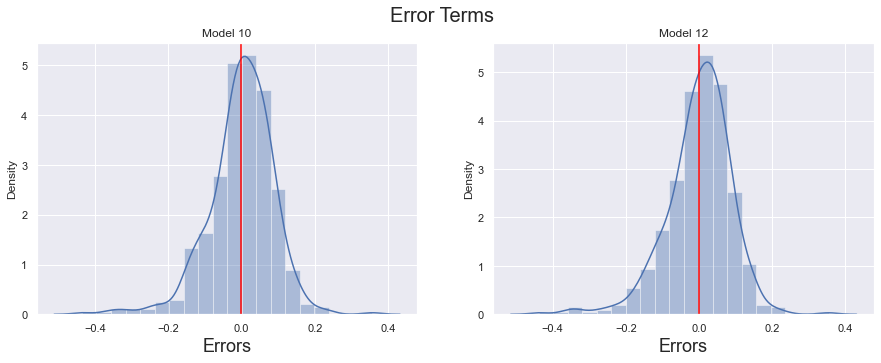

In [47]:
#predictions

y_train_pred_10 = linear_model_10.predict(X_train_sm_10)
y_train_pred_12 = linear_model_12.predict(X_train_sm_12)

#plotting error terms 
fig = plt.figure( figsize=(15,5))
fig.suptitle('Error Terms', fontsize = 20)

ax = plt.subplot(1,2,1)
sns.distplot((y_train - y_train_pred_10), bins = 20)
ax.axvline(x=(y_train - y_train_pred_10).mean(),
            color='red')
ax.set_title("Model 10")                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

ax = plt.subplot(1,2,2)
sns.distplot((y_train - y_train_pred_12), bins = 20)
ax.axvline(x=(y_train - y_train_pred_12).mean(),
            color='red')
ax.set_title("Model 12")                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label


plt.show()

The mean of the error terms is 0 and the errors appear to be normally distributed. 

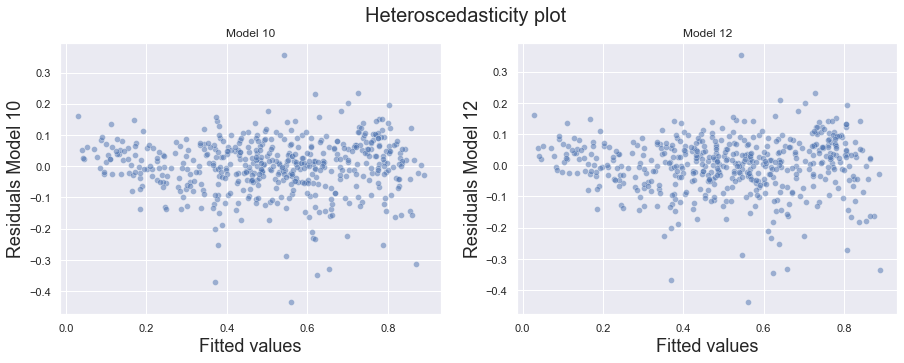

In [48]:
#testing heteroscedasticity
res_model_10 = y_train - y_train_pred_10
res_model_12 = y_train - y_train_pred_12


fig = plt.figure(figsize=(15,5))
fig.suptitle('Heteroscedasticity plot', fontsize = 20)

ax = plt.subplot(1,2,1)
sns.scatterplot(y_train_pred_10, res_model_10, alpha=0.5)
plt.xlabel('Fitted values',fontsize = 18)
plt.ylabel('Residuals Model 10',fontsize = 18)
ax.set_title("Model 10") 


ax = plt.subplot(1,2,2)
sns.scatterplot(y_train_pred_12, res_model_12, alpha=0.5)
plt.xlabel('Fitted values',fontsize = 18)
plt.ylabel('Residuals Model 12',fontsize = 18)
ax.set_title("Model 12") 

plt.show()

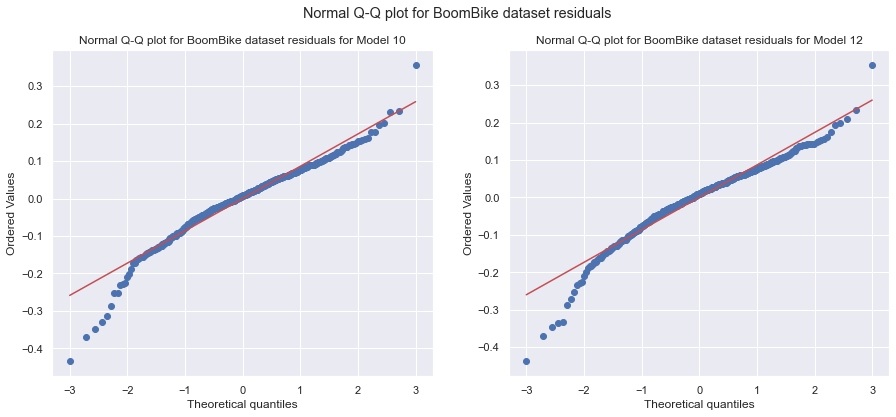

In [49]:
#Q-Q Plot using scipy 
import scipy.stats as stats

fig= plt.figure(figsize=(15,6))
fig.suptitle("Normal Q-Q plot for BoomBike dataset residuals")

ax = plt.subplot(1,2,1)
stats.probplot(res_model_10, dist="norm", plot=ax)
ax.set_title("Normal Q-Q plot for BoomBike dataset residuals for Model 10")

ax = plt.subplot(1,2,2)
stats.probplot(res_model_12, dist="norm", plot=ax)
ax.set_title("Normal Q-Q plot for BoomBike dataset residuals for Model 12")

plt.show()

The overall distribution does not take any specific shape indicating little heteoroscedasticity. Additionally, outside of the lower values in the Q-Q plot, there is clear linearity between the theoretical quantiles and the same quantiles which further indicates that the normality assumption of linear regression is obeyed. With these three plots, we can conclude that while not the perfect model for this dataset, a linear model does model the daily demand well.

### Step 5: Predictions and Evaluation of Test Set

In [50]:
bike_test[num_vars] = scaler.transform(bike_test[num_vars])
bike_test[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,219.0,0.558941,0.233698,0.046591,0.354650,0.558691,0.759096,0.984424
atemp,219.0,0.532991,0.217888,0.025950,0.344751,0.549198,0.714132,0.980934
hum,219.0,0.638508,0.148974,0.261915,0.527265,0.627737,0.743928,1.002146
windspeed,219.0,0.313350,0.159947,-0.042808,0.198517,0.299459,0.403048,0.807474
cnt,219.0,0.520592,0.218435,0.048205,0.377531,0.524275,0.672745,0.963300


In [51]:
X_train_sm_12.columns

Index(['const', 'Sat', 'September', 'October', 'summer', 'winter',
       'Light_Precip', 'Mist/Cloudy', 'yr', 'workingday', 'temp', 'hum',
       'windspeed'],
      dtype='object')

In [52]:
#dividing test set into response and predictors

y_test = bike_test.pop('cnt')
X_test = bike_test


In [53]:
#add constant
X_test_linear_model_10 = sm.add_constant(X_test)
X_test_linear_model_12 = sm.add_constant(X_test)

In [54]:
#selecting features needed for model
X_test_linear_model_10 = X_test_linear_model_10[['const', 'Sat', 'August', 'September', 'October', 'summer', 'winter',
       'Light_Precip', 'Mist/Cloudy', 'yr', 'workingday', 'temp', 'hum',
       'windspeed']]

X_test_linear_model_12 = X_test_linear_model_12[['const', 'Sat', 'September', 'October', 'summer', 'winter',
       'Light_Precip', 'Mist/Cloudy', 'yr', 'workingday', 'temp', 'hum',
       'windspeed']]

In [55]:
#evaluating on test set
from sklearn.metrics import r2_score

y_pred_model_10 = linear_model_10.predict(X_test_linear_model_10)
print('R-squared on Test Set for model 10: ',r2_score(y_test, y_pred_model_10))

y_pred_model_12 = linear_model_12.predict(X_test_linear_model_12)
print('R-squared on Test Set for model 12: ',r2_score(y_test, y_pred_model_12))

R-squared on Test Set for model 10:  0.8215325011676098
R-squared on Test Set for model 12:  0.8235109058870725


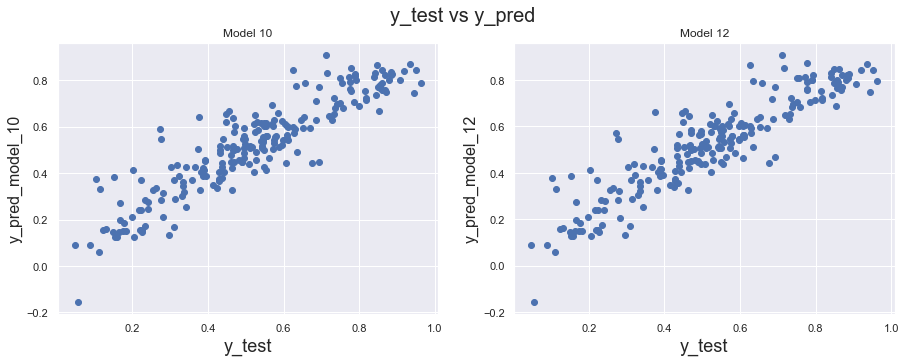

In [56]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure(figsize=(15,5))
fig.suptitle('y_test vs y_pred', fontsize = 20)  # Plot heading 

ax = plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_model_10)         
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred_model_10', fontsize = 16) 
ax.set_title("Model 10")


ax = plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_model_12)         
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred_model_12', fontsize = 16) 
ax.set_title("Model 12")


plt.show()

On the test set the model reached an r-squared value of 0.821 which is only slightly less than the r-squared on the training set. Additionaly the scatterplot of y_test vs y_pred show a clear linear relationship.

In [57]:
#mean squared error 
from sklearn.metrics import mean_squared_error

train_mse_10 = (mean_squared_error(y_true=y_train, y_pred=y_train_pred_10))
test_mse_10 = (mean_squared_error(y_true=y_test, y_pred=y_pred_model_10))
print("MODEL 10 MSE")
print('Mean squared error of the train set is', train_mse_10)
print('Mean squared error of the test set is', test_mse_10)

print("\n\nMODEL 12 MSE")
train_mse_12 = (mean_squared_error(y_true=y_train, y_pred=y_train_pred_12))
test_mse_12 = (mean_squared_error(y_true=y_test, y_pred=y_pred_model_12))
print('Mean squared error of the train set is', train_mse_12)
print('Mean squared error of the test set is', test_mse_12)

MODEL 10 MSE
Mean squared error of the train set is 0.007723613839469264
Mean squared error of the test set is 0.008476458085604125


MODEL 12 MSE
Mean squared error of the train set is 0.007845465402656345
Mean squared error of the test set is 0.008382492154604907


####                                                 <center> Summarising and Model Selection

|                  |  Model 10 | Model 12  |  Effect of Coef on Demand  |
|------------------|-----------|-----------|----------------------------|
|const             | 0.3239    | 0.3191    |  N/A intercept             |
|Sat               | 0.0614    | 0.0633    |  Increases Demand          |
|August            | 0.0486    | N/A       |  Increases Demand          |
|September         | 0.1183    | 0.1003    |  Increases Demand          |    
|October           | 0.0598    | 0.0590    |  Increases Demand          |
|summer            | -0.0918   | -0.0695   |  Decreases Demand          |
|winter            | -0.1330   | -0.1340   |  Decreases Demand          |
|Light_Precip      | -0.2531   | -0.2569   |  Decreases Demand          |
|Mist/Cloudy       | -0.0609   | -0.0599   |  Decreases Demand          |
|yr                | 0.2309    | 0.2319    |  Increases Demand          |
|workingday        | 0.0522    | 0.0534    |  Increases Demand          |
|temp              | 0.4715    | 0.4681    |  Increases Demand          |
|hum               | -0.1538   | -0.1457   |  Decreases Demand          |
|windspeed         | -0.1875   | -0.1873   |  Decreases Demand          |
|                  |           |           |                            |
|                  |           |           |  *STATISTICAL SUMMARIES*   |
|Adj. R-squared    | 0.843     | 0.840     |  Model 10 better r-squared |
|F-Statistic       | 210.5     | 224.3     |  Model 12 higher F stat    |
|Prob (F-statistic)| 2.78e-192 | 8.67e-192 |  Model 12 lower prob F stat|
|AIC               | -1005.    | -999.1    |  Model 10 lower AIC        |
|Features          |    13     | 12        |  Model 12 uses fewer       |
|R-Squared Test Set| 0.82153   | 0.82351   |  Model 12 better r-squared |
|MSE Train Set     | 0.007723  | 0.007845  |  Model 10 lower train mse  |
|MSE Test Set      | 0.00848   | 0.00838   |  Model 12 lower test mse   |

Of the 8 considerations taken for each model in Statistical summaries, model 12 beat model 10 in 5 of them. It should be noted that both models returned similar levels of performance.
That being said, I would select Model 12 due to its better performance on the test set and higher f statistic value and lower F Statistic p-value and the fact that this was all achieved using one less feature than Model 10. 

## Conclusions and Summary

1) Using manual and automatic feature selection (RFE), I was able to drop the number of initial features from 33 to 12 with only a minute drop in R-squared and a significant rise in the F statistic and significant drop in AIC while having all predictor p-values fall to near 0. This means the model is significantly less complex

2) On the training set, the model scored an R-squared value of 84.4% and on our test set, this score was 82.4%. This indicates the model does a very good job of predicting demand in the dataset.
 

3) The equation for the best fit line is:

 $ cnt = 0.3191 + 0.0633	\times Sat + 0.1003 \times	September + 0.0590	\times October - 0.0695 \times summer - 0.1340 \times winter - 0.2569 \times LightPrecip - 0.0599 \times Mist/Cloudy + 0.2319 \times yr + 0.0534 \times workingday + 0.4681	\times temp - 0.1457 \times hum - 0.1873 \times windspeed $
 
Based on the absolute values of the coeffients the following are the features with the most impact and their effect

|Position|Feature      | Coef   | Impact  |
|--------|-------------|--------|---------|
|   1    | temp        | 0.4681 | Increase|
|   2    | Light_Precip| -0.2569| Decrease|
|   3    | yr          |  0.2319| Increase|
|   4    | windspeed   | -0.1873| Decrease|
|   5    | hum         | -0.1457| Decrease|
|   6    | winter      | -0.134 | Decrease|
|   7    | September   | 0.1003 | Increase|
|   8    | summer      | -0.0695| Decrease|
|   9    | Sat         | 0.0633 | Increase|
|   10   | Mist/Cloudy | -0.0599| Decrease|
|   11   | October     | 0.059  | Increase|
|   12   | workingday  | 0.0534 | Increase|

 
#### Recommendations for BoomBike

Based on the available data, we can see that having a higher temperatures increases demand more so than all other features while Light_Precipe decreases more so than other features. That being said, the yr variable clearly indicates that 2019 was linked to higher demand for services. 

- We can expect higher demand in summer due to its higher temperatures. It is  likely the summer variable itself is linked to a decrease in usage not due to temperature but due to summer having a higher chance of light to heavy shower. In addition to this, we can also expect demand to be higher on days when persons are working and Saturdays likely due to persons taking the bike to work and using the bike for trips on Saturdays. 

For example warm Saturdays in September with clear skies, low humidity and calm winds in 2019 would have the highest demand for bikes